# Cleaning of Accident Data (2013-2017)

In [90]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import seaborn as sns
import urllib, os
import glob
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, auc, roc_curve, classification_report
import warnings
warnings.filterwarnings("ignore")

# Importing the data

In [91]:
accidents_df = pd.concat([pd.read_csv(f) for f in glob.glob('data/Accidents/Accidents*.csv')], ignore_index = True)

In [92]:
len(accidents_df)

691641

In [93]:
accidents_df.head()

,Accident_Index,Location_Easting_OSGR,Location_Northing_OSGR,Longitude,Latitude,Police_Force,Accident_Severity,Number_of_Vehicles,Number_of_Casualties,Date,...,Pedestrian_Crossing-Human_Control,Pedestrian_Crossing-Physical_Facilities,Light_Conditions,Weather_Conditions,Road_Surface_Conditions,Special_Conditions_at_Site,Carriageway_Hazards,Urban_or_Rural_Area,Did_Police_Officer_Attend_Scene_of_Accident,LSOA_of_Accident_Location
0,201301BS70003,527060.0,177970.0,-0.171402,51.486361,1,2,2,1,02/01/2013,...,0,0,1,1,1,0,0,1,1,E01002844
1,201301BS70005,526900.0,178940.0,-0.173356,51.495115,1,3,1,2,04/01/2013,...,0,5,1,8,1,0,0,1,1,E01002821
2,201301BS70006,524240.0,181460.0,-0.210767,51.518353,1,3,1,1,07/01/2013,...,0,1,1,1,1,0,0,1,1,E01002878
3,201301BS70007,524320.0,181290.0,-0.209675,51.516808,1,3,2,1,10/01/2013,...,0,5,1,1,1,0,0,1,1,E01002831
4,201301BS70009,525450.0,178660.0,-0.194332,51.492922,1,3,2,1,04/01/2013,...,0,0,4,1,1,0,0,1,1,E01002851


In [94]:
accidents_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 691641 entries, 0 to 691640
Data columns (total 32 columns):
Accident_Index                                 691641 non-null object
Location_Easting_OSGR                          691588 non-null float64
Location_Northing_OSGR                         691588 non-null float64
Longitude                                      691578 non-null float64
Latitude                                       691578 non-null float64
Police_Force                                   691641 non-null int64
Accident_Severity                              691641 non-null int64
Number_of_Vehicles                             691641 non-null int64
Number_of_Casualties                           691641 non-null int64
Date                                           691641 non-null object
Day_of_Week                                    691641 non-null int64
Time                                           691610 non-null object
Local_Authority_(District)                     691

# Cleaning

In [95]:
# First make initial list of column to drop that won't be useful
# Accident Severity should be object
# Date to date_time
# Day_of_Week to object
# Time to date_time
# 1st/2nd_Road_Class is object but are numbers
# Note Road_Type is object but are numbers
# Junction_Detail is float but should be objects
# Junction_Control is object but are numbers
# Light/Weather/Road_Surface_Conditions/Special_Conditions_at_Site/Carriageway_Hazards are objects but numbers
# Urban_or_Rural_Area is int should be strings
# Also note nulls are usually marked by -1
drop_list = ['Police_Force', 'Local_Authority_(District)', 'Local_Authority_(Highway)', 
             '1st_Road_Number', '2nd_Road_Number', 'Pedestrian_Crossing-Human_Control', 
             'Pedestrian_Crossing-Physical_Facilities','Did_Police_Officer_Attend_Scene_of_Accident']
accidents_df = accidents_df.drop(labels=drop_list, axis=1)
accidents_df.shape

(691641, 24)

## Deal with nulls

In [96]:
accidents_df.isna().sum()/len(accidents_df)

Accident_Index                0.000000
Location_Easting_OSGR         0.000077
Location_Northing_OSGR        0.000077
Longitude                     0.000091
Latitude                      0.000091
Accident_Severity             0.000000
Number_of_Vehicles            0.000000
Number_of_Casualties          0.000000
Date                          0.000000
Day_of_Week                   0.000000
Time                          0.000045
1st_Road_Class                0.000000
Road_Type                     0.000000
Speed_limit                   0.000053
Junction_Detail               0.000000
Junction_Control              0.000000
2nd_Road_Class                0.000000
Light_Conditions              0.000000
Weather_Conditions            0.000000
Road_Surface_Conditions       0.000000
Special_Conditions_at_Site    0.000000
Carriageway_Hazards           0.000000
Urban_or_Rural_Area           0.000000
LSOA_of_Accident_Location     0.062778
dtype: float64

In [97]:
# For Speed_limit replace NaNs with median value
accidents_df.Speed_limit.fillna(accidents_df.Speed_limit.median(), inplace=True)

## Correcting dtypes and labels

In [98]:
accidents_df.Accident_Severity.value_counts(normalize=True)

3    0.836837
2    0.151230
1    0.011932
Name: Accident_Severity, dtype: float64

In [99]:
# Change values to listed meanings
accidents_df.Accident_Severity = accidents_df.Accident_Severity.replace([1,2,3], ['Fatal', 'Serious', 'Slight'])

In [100]:
# Change Date to datetime
accidents_df['Date'] = pd.to_datetime(accidents_df['Date'], format='%d/%m/%Y')

In [101]:
# Take just hour from Time string and convert to datetime
# Can possibly label the times into groups later
accidents_df['Hour'] = pd.to_datetime(accidents_df['Time'], format='%H:%M').dt.hour

In [102]:
accidents_df = accidents_df.drop('Time', axis=1)

In [103]:
accidents_df.Hour.fillna(accidents_df.Hour.median(), inplace=True)

In [104]:
accidents_df.Hour = accidents_df.Hour.astype('int')

In [105]:
def two_hour_groupings(hour):
    '''Creates two hour bins from Hour column'''
    if hour >= 0 and hour < 2:
        return '12am-2am'
    if hour >= 2 and hour < 4:
        return '2am-4am'
    if hour >= 4 and hour < 6:
        return '4am-6am'
    if hour >= 6 and hour < 8:
        return '6am-8am'
    if hour >= 8 and hour < 10:
        return '8am-10am'
    if hour >= 10 and hour < 12:
        return '10am-12pm'
    if hour >= 12 and hour < 14:
        return '12pm-2pm'
    if hour >= 14 and hour < 16:
        return '2pm-4pm'
    if hour >= 16 and hour < 18:
        return '4pm-6pm'
    if hour >= 18 and hour < 20:
        return '6pm-8pm'
    if hour >= 20 and hour < 22:
        return '8pm-10pm'
    if hour >= 22 and hour < 24:
        return '10pm-12am'

In [106]:
# apply function (probably drop Hour later before modeling)
accidents_df['Two_Hour_Groupings'] = accidents_df['Hour'].apply(two_hour_groupings)

I kept the below function for possibly looking at during EDA

In [107]:
# Use function to group house into Time_of_Day
def Hour_to_groups(hour):
    if hour >= 5 and hour < 10:
        return 'Morning'
    elif hour >= 10 and hour < 15:
        return 'Office hours'
    elif hour >= 15 and hour < 19:
        return 'Rush hour'
    elif hour >= 19 and hour < 23:
        return 'Evening'
    else:
        return 'Night'

In [108]:
# apply function (probably drop Hour later before modeling)
accidents_df['Time_of_Day'] = accidents_df['Hour'].apply(Hour_to_groups)

In [109]:
accidents_df.Day_of_Week.value_counts(normalize=True)

6    0.163672
5    0.152089
3    0.151223
4    0.150698
2    0.141935
7    0.130423
1    0.109960
Name: Day_of_Week, dtype: float64

In [110]:
# Change Day_of_Week from int to object
accidents_df.Day_of_Week = accidents_df.Day_of_Week.replace([1,2,3,4,5,6,7], 
                                 ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday'])

In [111]:
accidents_df['1st_Road_Class'].value_counts(normalize=True)

3    0.454639
6    0.306250
4    0.123197
5    0.077224
1    0.035877
2    0.002814
Name: 1st_Road_Class, dtype: float64

In [112]:
accidents_df['1st_Road_Class'] = accidents_df['1st_Road_Class'].replace([1,2,3,4,5,6], 
                                                                        ['Motorway', 'A(M)', 'A', 'B', 
                                                                         'C', 'Unclassified'])
accidents_df['1st_Road_Class'].value_counts(normalize=True)

A               0.454639
Unclassified    0.306250
B               0.123197
C               0.077224
Motorway        0.035877
A(M)            0.002814
Name: 1st_Road_Class, dtype: float64

In [113]:
accidents_df.Road_Type.value_counts(normalize=True)

 6    0.745468
 3    0.146459
 1    0.067383
 2    0.021767
 7    0.010601
 9    0.008321
-1    0.000001
Name: Road_Type, dtype: float64

In [114]:
# Change Road_Type to proper labels
# Rather than dropping added unknown(9) and missing data(-1) to the mode ('Single carriageway')
accidents_df.Road_Type = accidents_df.Road_Type.replace([1,2,3,6,7,9,-1], 
                               ['Roundabout', 'One way street', 'Dual carriageway', 'Single carriageway', 
                                'Slip road', 'Single carriageway', 'Single carriageway'])
accidents_df.Road_Type.value_counts(normalize=True)

Single carriageway    0.753790
Dual carriageway      0.146459
Roundabout            0.067383
One way street        0.021767
Slip road             0.010601
Name: Road_Type, dtype: float64

In [115]:
accidents_df.Junction_Detail.value_counts(normalize=True)

 0    0.401522
 3    0.316150
 6    0.097717
 1    0.087626
 8    0.034965
 9    0.025311
 5    0.014574
 2    0.012800
 7    0.008289
-1    0.001047
Name: Junction_Detail, dtype: float64

In [116]:
# Change Junction_Detail to proper labels
# Rather than dropping added missing data(-1) to the mode (Not at junction or within 20 meters)
accidents_df.Junction_Detail = accidents_df.Junction_Detail.replace([0,1,2,3,5,6,7,8,9,-1], 
                                                                    ['Not at junction or within 20 meters', 
                                                                     'Roundabout', 'Mini-roundabout', 
                                                                     'T or staggered junction', 'Slip road', 
                                                                     'Crossroads', 
                                                                     'More than 4 arms (not roundabout)', 
                                                                     'Private drive or entrance', 'Other junction', 
                                                                     'Not at junction or within 20 meters'])
accidents_df.Junction_Detail.value_counts(normalize=True)

Not at junction or within 20 meters    0.402569
T or staggered junction                0.316150
Crossroads                             0.097717
Roundabout                             0.087626
Private drive or entrance              0.034965
Other junction                         0.025311
Slip road                              0.014574
Mini-roundabout                        0.012800
More than 4 arms (not roundabout)      0.008289
Name: Junction_Detail, dtype: float64

In [117]:
accidents_df.Junction_Control.value_counts(normalize=True)

 4    0.482139
-1    0.405216
 2    0.105125
 3    0.005081
 1    0.001878
 0    0.000561
Name: Junction_Control, dtype: float64

In [118]:
# Change Junction_Control to proper labels
accidents_df.Junction_Control = accidents_df.Junction_Control.replace([0,1,2,3,4,-1], 
                                                                      ['Not at junction or within 20 metres', 
                                                                       'Authorised person', 'Auto traffic signal', 
                                                                       'Stop sign', 'Give way or uncontrolled', 
                                                                       'Data missing or out of range'])
accidents_df.Junction_Control.value_counts(normalize=True)

Give way or uncontrolled               0.482139
Data missing or out of range           0.405216
Auto traffic signal                    0.105125
Stop sign                              0.005081
Authorised person                      0.001878
Not at junction or within 20 metres    0.000561
Name: Junction_Control, dtype: float64

In [119]:
# Drop Junction_Control because majority of the feature data is missing
accidents_df = accidents_df.drop('Junction_Control', axis=1)

In [120]:
accidents_df['2nd_Road_Class'].value_counts(normalize=True)

 6    0.406821
-1    0.406115
 3    0.098274
 5    0.042593
 4    0.039237
 1    0.006246
 2    0.000714
Name: 2nd_Road_Class, dtype: float64

In [121]:
# Change 2nd_Road_Class to proper labels
accidents_df['2nd_Road_Class'] = accidents_df['2nd_Road_Class'].replace([1,2,3,4,5,6,-1], 
                                                                        ['Motorway', 'A(M)', 'A', 'B', 'C', 
                                                                         'Unclassified', 
                                                                         'Not at junction or within 20 meters'])
accidents_df['2nd_Road_Class'].value_counts(normalize=True)

Unclassified                           0.406821
Not at junction or within 20 meters    0.406115
A                                      0.098274
C                                      0.042593
B                                      0.039237
Motorway                               0.006246
A(M)                                   0.000714
Name: 2nd_Road_Class, dtype: float64

In [122]:
accidents_df.Light_Conditions.value_counts(normalize=True)

 1    0.728686
 4    0.198545
 6    0.051253
 7    0.015485
 5    0.006010
-1    0.000020
Name: Light_Conditions, dtype: float64

In [123]:
# Change Light_Conditions to proper labels
# Add missing data(-1) to mode (Daylight)
accidents_df.Light_Conditions = accidents_df.Light_Conditions.replace([1,4,5,6,7,-1], 
                                                      ['Daylight', 
                                                       'Darkness - lights lit', 
                                                       'Darkness - lights unlit', 
                                                       'Darkness - no lighting', 
                                                       'Darkness - lighting unknown', 
                                                       'Daylight'])

accidents_df.Light_Conditions.value_counts(normalize=True)

Daylight                       0.728706
Darkness - lights lit          0.198545
Darkness - no lighting         0.051253
Darkness - lighting unknown    0.015485
Darkness - lights unlit        0.006010
Name: Light_Conditions, dtype: float64

In [124]:
accidents_df.Weather_Conditions.value_counts(normalize=True)

 1    0.812651
 2    0.110719
 9    0.022883
 8    0.016841
 5    0.013507
 4    0.012032
 3    0.005047
 7    0.004920
 6    0.001378
-1    0.000020
Name: Weather_Conditions, dtype: float64

In [125]:
# Change Weather_Conditions to proper labels
# Add unknown(9) and missing data(-1) to mode (Fine no high winds)
accidents_df.Weather_Conditions = accidents_df.Weather_Conditions.replace([1,2,3,4,5,6,7,8,9,-1], 
                                                                ['Fine no high winds', 
                                                                 'Raining no high winds', 
                                                                 'Snowing no high winds', 
                                                                 'Fine + high winds', 
                                                                 'Raining + high winds', 
                                                                 'Snowing + high winds', 
                                                                 'Fog or mist', 'Other', 'Fine no high winds', 
                                                                 'Fine no high winds'])
accidents_df.Weather_Conditions.value_counts(normalize=True)

Fine no high winds       0.835555
Raining no high winds    0.110719
Other                    0.016841
Raining + high winds     0.013507
Fine + high winds        0.012032
Snowing no high winds    0.005047
Fog or mist              0.004920
Snowing + high winds     0.001378
Name: Weather_Conditions, dtype: float64

In [126]:
accidents_df.Road_Surface_Conditions.value_counts(normalize=True)

 1    0.711846
 2    0.262678
 4    0.014380
-1    0.005018
 3    0.004780
 5    0.001297
Name: Road_Surface_Conditions, dtype: float64

In [127]:
# Change Road_Surface_Conditions to proper labels
# Add missing data(-1) to mode (Dry)
accidents_df.Road_Surface_Conditions = accidents_df.Road_Surface_Conditions.replace([1,2,3,4,5,-1], 
                                                                                    ['Dry', 
                                                                                     'Wet or damp', 
                                                                                     'Snow', 
                                                                                     'Frost or ice', 
                                                                                     'Flood over 3cm. deep', 
                                                                                     'Dry'])
accidents_df.Road_Surface_Conditions.value_counts(normalize=True)

Dry                     0.716865
Wet or damp             0.262678
Frost or ice            0.014380
Snow                    0.004780
Flood over 3cm. deep    0.001297
Name: Road_Surface_Conditions, dtype: float64

In [128]:
accidents_df.Special_Conditions_at_Site.value_counts(normalize=True)

 0    0.974209
 4    0.010630
-1    0.004074
 7    0.002822
 6    0.002568
 5    0.002251
 1    0.001822
 3    0.001229
 2    0.000395
Name: Special_Conditions_at_Site, dtype: float64

In [129]:
# Change Special_Conditions_at_Site to proper labels
# Add missing data (-1) to mode (None)
accidents_df.Special_Conditions_at_Site = \
accidents_df.Special_Conditions_at_Site.replace([0,1,2,3,4,5,6,7,-1],  
                                                ['None', 'Auto traffic singal - out', 
                                                 'Auto signal part defective', 
                                                 'Road sign or marking defective or obscured', 
                                                 'Roadworks', 'Road surface defective', 
                                                 'Oil or diesel', 'Mud', 'None'])

accidents_df.Special_Conditions_at_Site.value_counts(normalize=True)

None                                          0.978284
Roadworks                                     0.010630
Mud                                           0.002822
Oil or diesel                                 0.002568
Road surface defective                        0.002251
Auto traffic singal - out                     0.001822
Road sign or marking defective or obscured    0.001229
Auto signal part defective                    0.000395
Name: Special_Conditions_at_Site, dtype: float64

In [130]:
accidents_df.Carriageway_Hazards.value_counts(normalize=True)

 0    0.979288
 2    0.007258
 7    0.004437
-1    0.003928
 6    0.002380
 3    0.001413
 1    0.001295
Name: Carriageway_Hazards, dtype: float64

In [131]:
# Change Carriageway_Hazards to proper labels
# Add missing data(-1) to mode (None)
accidents_df.Carriageway_Hazards = \
accidents_df.Carriageway_Hazards.replace([0,1,2,3,6,7,-1],  
                                                ['None', 'Vehicle load on road', 
                                                 'Other object on road', 
                                                 'Previous accident',  
                                                 'Pedestrian in carriageway - not injured', 
                                                 'Any animal in carriageway (except ridden horse)', 
                                                 'None'])

accidents_df.Carriageway_Hazards.value_counts(normalize=True)

None                                               0.983217
Other object on road                               0.007258
Any animal in carriageway (except ridden horse)    0.004437
Pedestrian in carriageway - not injured            0.002380
Previous accident                                  0.001413
Vehicle load on road                               0.001295
Name: Carriageway_Hazards, dtype: float64

In [132]:
accidents_df.Urban_or_Rural_Area.value_counts(normalize=True)

1    0.656437
2    0.343538
3    0.000025
Name: Urban_or_Rural_Area, dtype: float64

In [133]:
# Change Urban_or_Rural_Area to proper labels
# Add unallocated (3) to mode (Urban)
accidents_df.Urban_or_Rural_Area = accidents_df.Urban_or_Rural_Area.replace([1,2,3], ['Urban', 'Rural', 'Urban'])
accidents_df.Urban_or_Rural_Area.value_counts(normalize=True)

Urban    0.656462
Rural    0.343538
Name: Urban_or_Rural_Area, dtype: float64

In [134]:
# Rest of the rows with missing values are small enough to drop
# Also are from features that wouldn't make sense to impute with another value
accidents_df = accidents_df.dropna()

In [135]:
accidents_df.columns.groupby(accidents_df.dtypes)

{dtype('int64'): Index(['Number_of_Vehicles', 'Number_of_Casualties'], dtype='object'),
 dtype('float64'): Index(['Location_Easting_OSGR', 'Location_Northing_OSGR', 'Longitude',
        'Latitude', 'Speed_limit'],
       dtype='object'),
 dtype('<M8[ns]'): Index(['Date'], dtype='object'),
 dtype('int32'): Index(['Hour'], dtype='object'),
 dtype('O'): Index(['Accident_Index', 'Accident_Severity', 'Day_of_Week', '1st_Road_Class',
        'Road_Type', 'Junction_Detail', '2nd_Road_Class', 'Light_Conditions',
        'Weather_Conditions', 'Road_Surface_Conditions',
        'Special_Conditions_at_Site', 'Carriageway_Hazards',
        'Urban_or_Rural_Area', 'LSOA_of_Accident_Location',
        'Two_Hour_Groupings', 'Time_of_Day'],
       dtype='object')}

## Further Feature Selection 

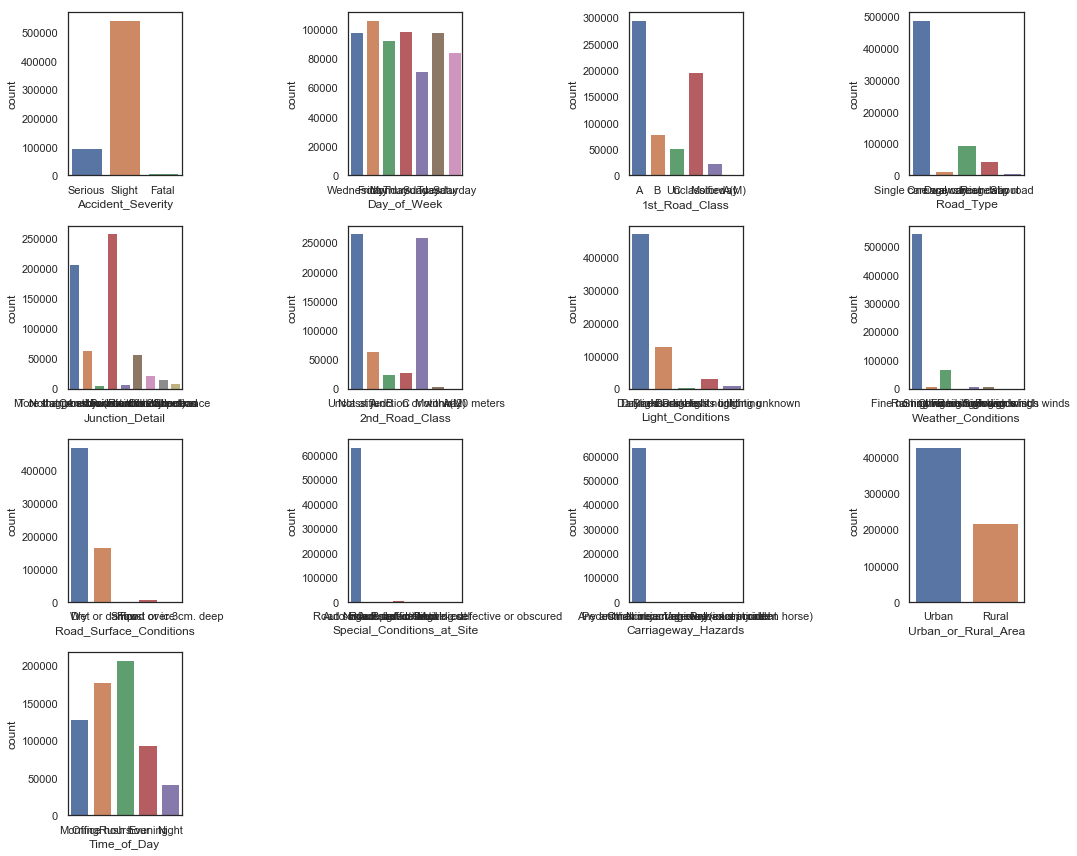

In [136]:
fig = plt.figure(figsize=(15,12))
ax1 = plt.subplot(441)
sns.countplot(accidents_df['Accident_Severity'])
ax2 = plt.subplot(442)
sns.countplot(accidents_df['Day_of_Week'])
ax3 = plt.subplot(443)
sns.countplot(accidents_df['1st_Road_Class'])
ax4 = plt.subplot(444)
sns.countplot(accidents_df['Road_Type'])
ax5 = plt.subplot(445)
sns.countplot(accidents_df['Junction_Detail'])
ax6 = plt.subplot(446)
sns.countplot(accidents_df['2nd_Road_Class'])
ax7 = plt.subplot(447)
sns.countplot(accidents_df['Light_Conditions'])
ax8 = plt.subplot(448)
sns.countplot(accidents_df['Weather_Conditions'])
ax9 = plt.subplot(449)
sns.countplot(accidents_df['Road_Surface_Conditions'])
ax10 = plt.subplot(4,4,10)
sns.countplot(accidents_df['Special_Conditions_at_Site'])
ax11 = plt.subplot(4,4,11)
sns.countplot(accidents_df['Carriageway_Hazards'])
ax12 = plt.subplot(4,4,12)
sns.countplot(accidents_df['Urban_or_Rural_Area'])
ax13 = plt.subplot(4,4,13)
sns.countplot(accidents_df['Time_of_Day'])
plt.tight_layout()
plt.show()

Drop `Special_Conditions_at_Site` and `Carriageway_Hazards` due to one dominant label.

In [137]:
accidents_df = accidents_df.drop(columns=['Special_Conditions_at_Site', 'Carriageway_Hazards'])

Also possibly change `Light_Conditions`, `Weather_Conditions`, and `Road_Surface_Conditions` to binary (might have to drop one since they are possibly collinear to each other).

In [138]:
accidents_df.Light_Conditions.value_counts(normalize=True)

Daylight                       0.727956
Darkness - lights lit          0.200164
Darkness - no lighting         0.049813
Darkness - lighting unknown    0.016103
Darkness - lights unlit        0.005964
Name: Light_Conditions, dtype: float64

In [139]:
def was_daylight(condition):
    if condition == 'Daylight':
        return 'Yes'
    else:
        return 'No'

In [140]:
accidents_df['Was_Daylight'] = accidents_df['Light_Conditions'].apply(was_daylight)

In [141]:
accidents_df.Weather_Conditions.value_counts(normalize=True)

Fine no high winds       0.840448
Raining no high winds    0.107624
Other                    0.016843
Raining + high winds     0.012683
Fine + high winds        0.011700
Fog or mist              0.004983
Snowing no high winds    0.004566
Snowing + high winds     0.001152
Name: Weather_Conditions, dtype: float64

In [142]:
def was_bad_weather(condition):
    if condition == 'Fine no high winds':
        return 'No'
    else:
        return 'Yes'

In [143]:
accidents_df['Was_Bad_Weather'] = accidents_df['Weather_Conditions'].apply(was_bad_weather)

In [144]:
accidents_df.Road_Surface_Conditions.value_counts(normalize=True)

Dry                     0.724585
Wet or damp             0.256415
Frost or ice            0.013635
Snow                    0.004179
Flood over 3cm. deep    0.001186
Name: Road_Surface_Conditions, dtype: float64

In [145]:
def was_road_dry(condition):
    if condition == 'Dry':
        return 'Yes'
    else:
        return 'No'

In [146]:
accidents_df['Was_Road_Dry'] = accidents_df['Road_Surface_Conditions'].apply(was_road_dry)

In [147]:
accidents_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Location_Easting_OSGR,648208.0,457684.471736,88611.341073,90185.000000,398206.750000,459530.500000,528820.000000,655391.000000
Location_Northing_OSGR,648208.0,263312.280412,122443.236168,10290.000000,174840.000000,217436.000000,366841.250000,656404.000000
Longitude,648208.0,-1.164207,1.282775,-6.317417,-2.027918,-1.121212,-0.142525,1.759641
Latitude,648208.0,52.257879,1.105293,49.912941,51.460000,51.842163,53.193894,55.800956
Number_of_Vehicles,648208.0,1.843288,0.712747,1.000000,1.000000,2.000000,2.000000,67.000000
Number_of_Casualties,648208.0,1.327304,0.804570,1.000000,1.000000,1.000000,1.000000,93.000000
Speed_limit,648208.0,37.858172,13.849555,0.000000,30.000000,30.000000,40.000000,70.000000
Hour,648208.0,13.549365,5.101049,0.000000,10.000000,14.000000,17.000000,23.000000


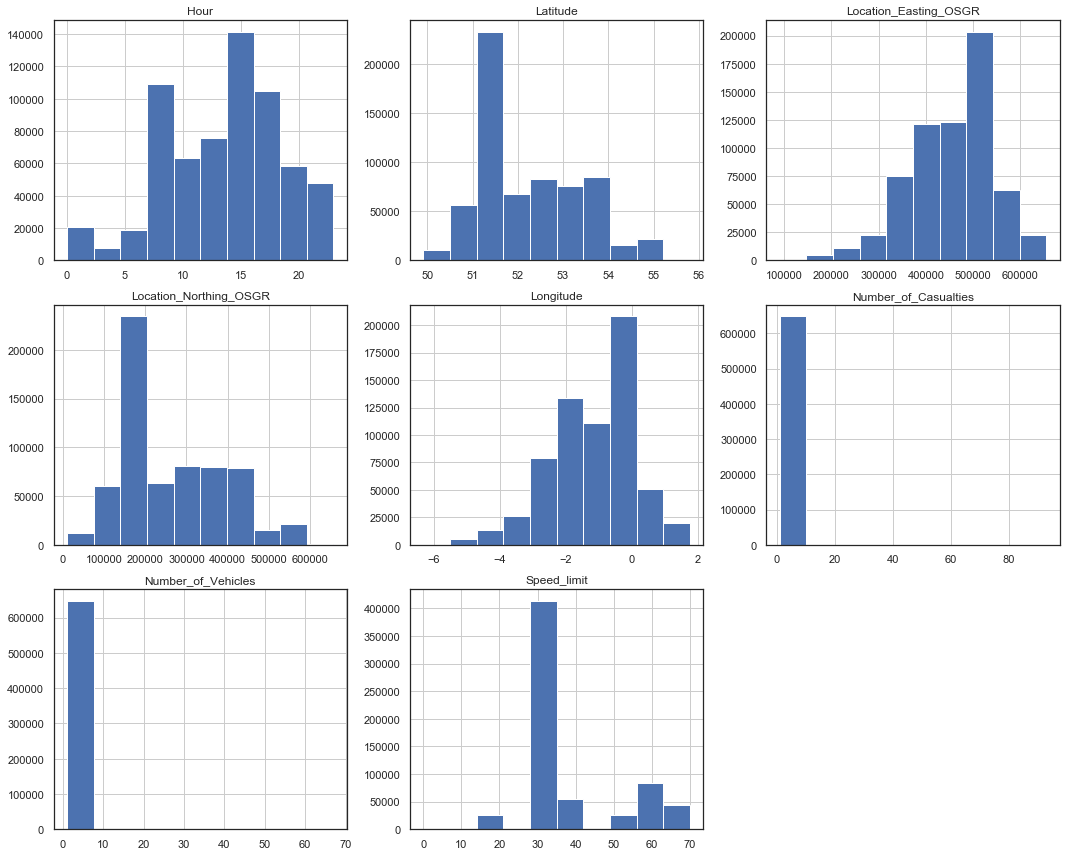

In [148]:
accidents_df.hist(figsize=(15,12))
plt.tight_layout()
plt.show()

Looks like need to log transform `Number_of_Vehicles` and `Number_of_Casualties`.

## Log Transform

In [149]:
accidents_df['log_Number_of_Casualties'] = np.log(accidents_df.Number_of_Casualties)
accidents_df['log_Number_of_Vehicles'] = np.log(accidents_df.Number_of_Vehicles)

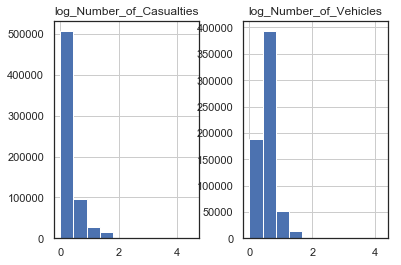

In [150]:
accidents_df[['log_Number_of_Casualties', 'log_Number_of_Vehicles']].hist()
plt.show()

## Collinearity

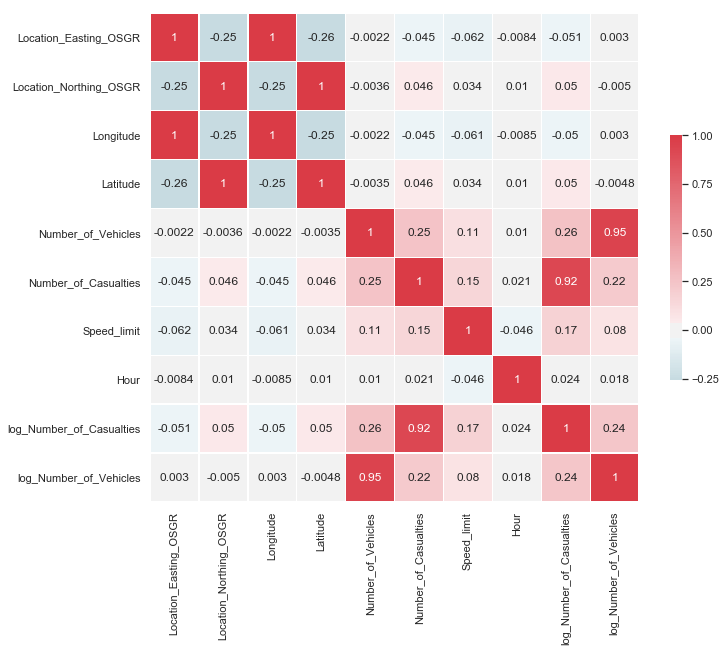

In [151]:
# Set the style of the visualization
sns.set(style="white")

# Create a covariance matrix
corr = accidents_df.corr()

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11,9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True);

Obivous colliearity with latitude and longitude with northing and easting but will leave those and LSOA for now for adding other datasets later.

In [152]:
accidents_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 648208 entries, 0 to 684527
Data columns (total 28 columns):
Accident_Index               648208 non-null object
Location_Easting_OSGR        648208 non-null float64
Location_Northing_OSGR       648208 non-null float64
Longitude                    648208 non-null float64
Latitude                     648208 non-null float64
Accident_Severity            648208 non-null object
Number_of_Vehicles           648208 non-null int64
Number_of_Casualties         648208 non-null int64
Date                         648208 non-null datetime64[ns]
Day_of_Week                  648208 non-null object
1st_Road_Class               648208 non-null object
Road_Type                    648208 non-null object
Speed_limit                  648208 non-null float64
Junction_Detail              648208 non-null object
2nd_Road_Class               648208 non-null object
Light_Conditions             648208 non-null object
Weather_Conditions           648208 non-null o

In [153]:
accidents_df.to_csv('data/accidents/Accidents.csv', index=False)

### Columns to drop before modeling:
- Accident_Index
- Location columns (LSOA/Easting/Northing/etc)
- Number_of_Vehicles
- Number_of_Casualties
- 2nd_Road_Class ?
- Light_Conditions
- Weather_Conditions
- Road_Surface_Conditions
- Hour ?

In [71]:
#final_accidents_df = accidents_df.drop(columns=['Accident_Index', 'Location_Easting_OSGR', 'Location_Northing_OSGR', 
                                                'Longitude', 'Latitude', 'Number_of_Vehicles', 'Number_of_Casualties', 
                                                'Light_Conditions', 'Weather_Conditions', 'Road_Surface_Conditions', 
                                                'Hour'])

# Pre EDA

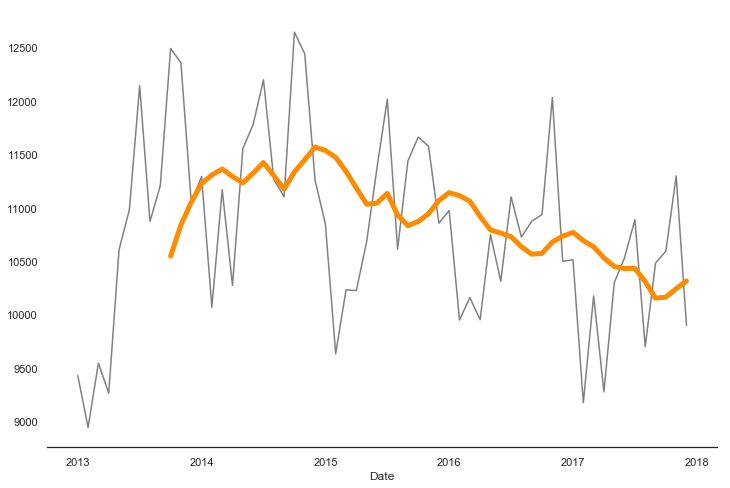

In [62]:
fig, ax = plt.subplots(figsize=(12,8))

accidents_df.set_index('Date').resample('M').size().plot(label='Total per Month', color='grey', ax=ax)
accidents_df.set_index('Date').resample('M').size().rolling(window=10).mean()\
                    .plot(color='darkorange', linewidth=5, label='10-Months Moving Average', ax=ax)

sns.despine(ax=ax, top=True, bottom=False, left=True, right=True)

In [63]:
accidents_df['Date'].dt.year.value_counts().sort_index(ascending=False)

2017    122841
2016    128270
2015    131156
2014    137045
2013    128896
Name: Date, dtype: int64

In [64]:
weekday_counts = pd.DataFrame(accidents_df.set_index('Date').resample('1d')['Accident_Index'].size().reset_index())
weekday_counts.columns = ['Date', 'Count']

weekday = weekday_counts['Date'].dt.weekday_name

In [65]:
weekday_averages = weekday_counts.groupby(weekday)['Count'].mean().reset_index()
weekday_averages.columns = ['Weekday', 'Average_accidents']
weekday_averages.set_index('Weekday', inplace=True)
weekday_averages

,Average_accidents
Weekday,
Friday,406.042146
Monday,354.265385
Saturday,322.954023
Sunday,272.977011
Thursday,377.862069
Tuesday,376.042146
Wednesday,374.770115


In [66]:
days = ['Sunday', 'Saturday', 'Friday', 'Thursday', 'Wednesday', 'Tuesday', 'Monday']
weekday_averages.reindex(days)

,Average_accidents
Weekday,
Sunday,272.977011
Saturday,322.954023
Friday,406.042146
Thursday,377.862069
Wednesday,374.770115
Tuesday,376.042146
Monday,354.265385
